<div>
    <img src = "https://media.winefolly.com/Different-Types-of-Wine-v2.jpg" width="600">
</div>

# Predicting Wine Quality

Wine has a long and interesting history. It has been dated back as far as [6000 B.C.](https://en.wikipedia.org/wiki/History_of_wine), and has only continued to rise in popularity. There are so many wines available today, and it can definitely be daunting to try and enter the world of wine with no experience. How do you choose a wine? What makes a wine good? Are there different qualities of wine? 

## Project Goals

* In this project we aim to build a machine learning model that can predict the quality of a wine given its chemical properties such as its acidity levels, sulfur dioxide levels, pH, sulphates, alcohol, etc. We will employ the usage of several machine learning models & machine learning techniques to help us create a model to accurately predict wine quality.
* Ideally we want our model to have a high precision, recall, and f1-score so we know that it is accurately predicting the correct quality for a given wine.

# Import Libraries & Tools

In [1]:
#import the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

#tools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

#color palette
wine_colors = ['#ffb9b9', '#ee7272', '#a31818', '#6d0202', '#4d0000', '#260000']

# Data Exploration

For the sake of this project we will only closely examine the red wine dataset. The same process could then later be applied to the white wine dataset if needed.

In [2]:
#read in our data
red_wine = pd.read_csv('winequality-red.csv', sep=';')
white_wine = pd.read_csv('winequality-white.csv', sep=';')
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
#inspect datatypes
print(red_wine.info())
print(red_wine['quality'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None
5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64


## Data Description

Input variables (based on physicochemical tests):

* **fixed acidity** : most acids involved with wine or fixed or nonvolatile (do not evaporate readily).
* **volatile acidity** : the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste.
* **citric acid** : found in small quantities, citric acid can add 'freshness' and flavor to wines.
* **residual sugar** : the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 gram/liter and wines with greater than 45 grams/liter are considered sweet.
* **chlorides** : the amount of salt in the wine.
* **free sulfur dioxide** : the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine.
* **total sulfur dioxide** : amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine.
* **density** : the density of water is close to that of water depending on the percent alcohol and sugar content.
* **pH** : describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale.
* **sulphates** : a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant.
* **alcohol** : the percent alcohol content of the wine.

Output variable (based on sensory data):

* **quality** : score between 0 and 10 given by human wine tasters.

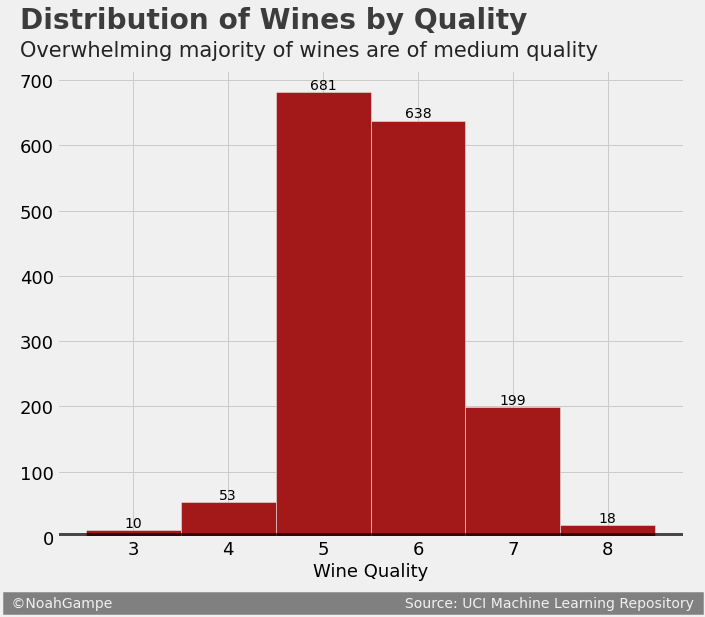

In [4]:
def plot_dist(df, col, title, sub):
    #figure details
    fig = plt.figure(figsize=(10,8))
            
    #plot
    ax = sns.histplot(data=df, x=col, bins=6, discrete=True, alpha=1, legend=False, color=wine_colors[2])
    for i in ax.containers:
        ax.bar_label(i,)
    
    #styling
    ax.axhline(y = 0, color = "black", linewidth = 8, alpha = .7)
    ax.set_xlabel('Wine Quality', fontsize=18)
    ax.yaxis.label.set_visible(False)
    ax.tick_params(labelsize=18)
    
    #title & subtitle
    ax.text(-0.06,1.09, s=title, fontsize=28, weight="bold", alpha=.75, transform=ax.transAxes)
    ax.text(-0.06,1.03, s=sub, fontsize=21, alpha=.85, transform=ax.transAxes)
    
    #signature bar
    ax.text(x=-0.08, y=-0.15,
            s=" ©NoahGampe" + ' '*65 + "Source: UCI Machine Learning Repository ",
            fontsize=14, color="#f0f0f0", backgroundcolor="grey", transform=ax.transAxes)
    
    plt.show()
    
title = "Distribution of Wines by Quality"
sub = "Overwhelming majority of wines are of medium quality"
plot_dist(red_wine, 'quality', title, sub)

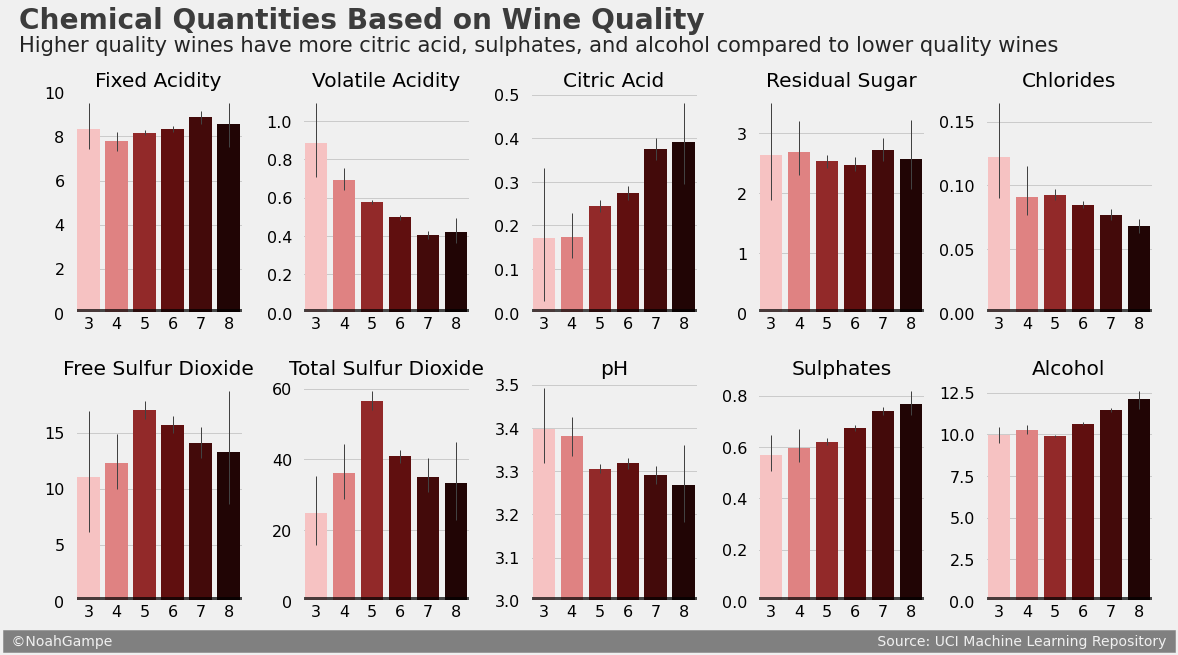

In [5]:
def plot_multi_dist(df, title, sub):
    #figure details
    fig = plt.figure(figsize=(16,8))
    
    #cols to plot
    cols = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides",
            "free sulfur dioxide", "total sulfur dioxide", "pH", "sulphates", "alcohol"]
    
    #titles for each plot
    titles = ["Fixed Acidity", "Volatile Acidity", "Citric Acid", "Residual Sugar", "Chlorides",
              "Free Sulfur Dioxide", "Total Sulfur Dioxide", "pH", "Sulphates", "Alcohol"]
    
    #loop to plot
    for i, col in enumerate(cols):
        ax = fig.add_subplot(2,5,i+1)
            
        #plot
        ax = fig.tight_layout(pad = 1, h_pad=2)
        ax = sns.barplot(data=df, x=df["quality"], y=df[col], alpha=1, errwidth=1, palette=wine_colors)
    
        #lines, labels, and limits
        ax.axhline(y=0, color='black', linewidth=8, alpha=.7)
        ax.yaxis.label.set_visible(False)
        ax.xaxis.label.set_visible(False)
        ax.tick_params(labelsize=16)
        ax.tick_params(axis='y', pad=10)
        
        if i == 7:
            ax.set_ylim(3,3.51)
            ax.axhline(y=3, color='black', linewidth=8, alpha=.7)
    
        #axes title
        ax.set_title(titles[i])
    
    #figure title & subtitle
    ax.text(-0.01,1.05, s=title, fontsize=28, weight='bold', alpha=.75, transform=fig.transFigure)
    ax.text(-0.01,1.01, s=sub, fontsize=21, alpha=.85, transform=fig.transFigure)
    
    #signature bar
    ax.text(x=-0.02, y=-0.02,
            s=' ©NoahGampe' + ' '*170 + 'Source: UCI Machine Learning Repository ',
            fontsize=14, color='#f0f0f0', backgroundcolor='grey', transform=fig.transFigure)
    
    plt.show()
    
title = "Chemical Quantities Based on Wine Quality"
sub = "Higher quality wines have more citric acid, sulphates, and alcohol compared to lower quality wines"
plot_multi_dist(red_wine, title, sub)

## Observations

* There are **11** characteristics of wine, and they are all represented by a `float64` datatype
* Quality is represented by an `int64` datatype
* There are no missing values
* All wines fall between **3** & **8** on the quality scale
* The overwhelmind majority of the wines have a quality of **5** & **6**
* Only **0.6%** of the wines have a quality of **3**, and **1.13%** of the wines have a quality of **8**
* Wines with a quality of **8** are *higher* in `citric acid`, `sulphates`, and `alcohol`, and *lower* in `volatile acidity`, `chlorides`, and `pH`

# What Makes Wine "Good"?

The quality and "goodness" of a wine can be heavily subjective. Everyone has different preferences and tastes, making the task to quantify a wine's quality difficult. However, several things can heavily affect the grapes used to make the wine, such as climate, weather, harvesting techniques, and winemaking practices.

> * Cooler climates produce wines higher in acidity but lower in sugar and alcohol. Hotter climates encourage ripening, leading to wines with higher sugars, higher alcohol and fuller body.
> * Canopy management often includes removing extra leaves and shoots to increase sunlight exposure, while pruning removes select branches to control yields and keep vines healthy. Harvesting is another crucial factor, since a harvest that is too early or late can lead to grapes lacking their ideal balance.
> * Wineries follow four main steps when producing their wines, maceration, fermentation, extraction and aging, and they must ensure consistency to get the most from their grapes. Inputs such as sulfur dioxide and processing enzymes, as well as [decisions with oak barrel aging and oxygen management](https://www.wineland.co.za/effect-of-viticultural-and-winemaking-practices-on-the-phenolic-composition-of-grapes-and-wines-part-ii/), all contribute to the quality of wine – from the exceptional to the insipid.
> The five components – acidity, tannins, sugar/sweetness, alcohol and fruit – need to be balanced. For wines that need several years of aging to reach maturity, this gives them the time they need to reach optimal balance.
>
> — [JJ Buckley Fine Wines](https://www.jjbuckley.com/wine-knowledge/blog/the-4-factors-and-4-indicators-of-wine-quality/1009), 2018

We can easily see in our data that we have several columns dealing with acidity, sugar, and alcohol. But how do any of these things affect the overall quality of the finished wine? To find out, we can make a correlation heatmap.

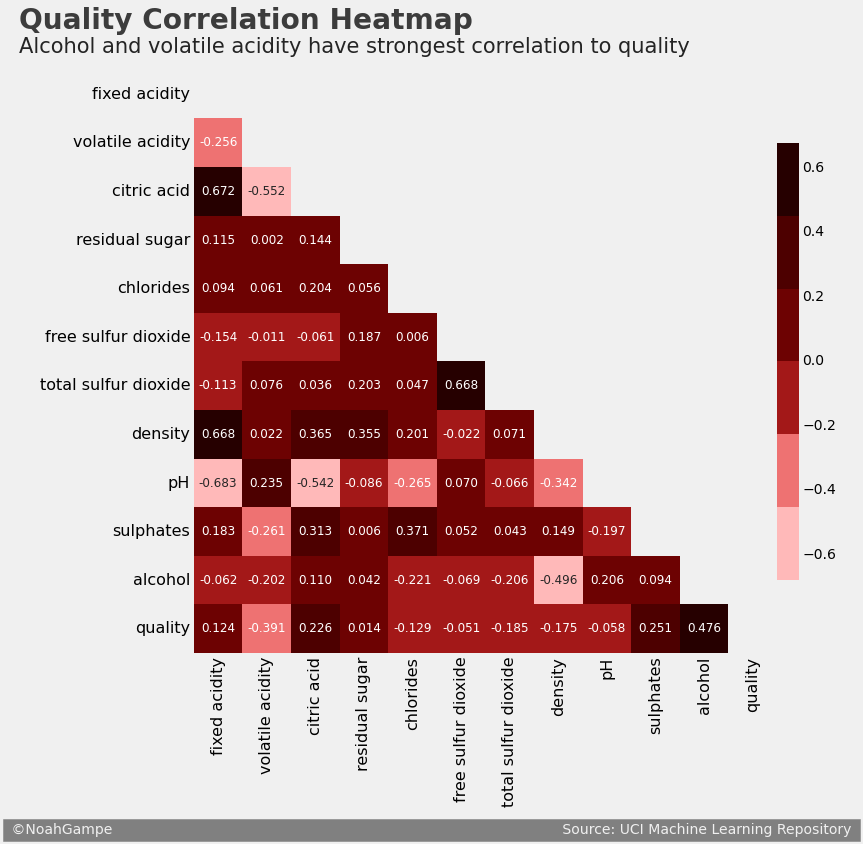

In [6]:
def plot_corr(df):
    data = df.corr()
    shrink = 0.75
    pad = 0
    fig_h = 10
    title = "Quality Correlation Heatmap"
    sub = "Alcohol and volatile acidity have strongest correlation to quality"
        
    if data.shape[0] == data.shape[1]:
        mask = np.zeros_like(data, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
    else:
        mask = False
        
    #figure details
    fig = plt.figure(figsize=(16,fig_h))
    fig.tight_layout()
    
    #plot details
    ax = sns.heatmap(data, square=True, mask=mask, cmap=wine_colors, fmt='.3f', annot=True,
                     annot_kws={'fontsize':12}, cbar_kws={'shrink': shrink, 'pad': pad})
              
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90, fontsize = 16)

    #title & subtitle
    ax.text(-0.3,1.07, s=title, fontsize=28, weight="bold", alpha=.75, transform=ax.transAxes)
    ax.text(-0.3,1.03, s=sub, fontsize=21, alpha=.85, transform=ax.transAxes)
    
    #signature bar
    ax.text(x=-0.32, y=-0.31,
            s=" ©NoahGampe" + ' '*100 + "Source: UCI Machine Learning Repository ",
            fontsize=14, color="#f0f0f0", backgroundcolor="grey", transform=ax.transAxes)
    
    plt.show()
    
plot_corr(red_wine)

In [7]:
#get correlation values between 'quality' and other columns
red_corr = red_wine.corr()['quality'][:-1].abs().sort_values(ascending=False)
red_corr

alcohol                 0.476166
volatile acidity        0.390558
sulphates               0.251397
citric acid             0.226373
total sulfur dioxide    0.185100
density                 0.174919
chlorides               0.128907
fixed acidity           0.124052
pH                      0.057731
free sulfur dioxide     0.050656
residual sugar          0.013732
Name: quality, dtype: float64

## Observations

* Looking at the correlation heatmap, we can clearly see that `alcohol` has the strongest positive correlation to quality
* Conversely, `volatile acidity` has the strongest negative correlation to quality
* Things like `residual sugar`, `free sulfur dioxide`, and `pH` don't have much of an effect on a wine's quality

# Preparing Data for Modeling



In [8]:
#separate data into features and target
X = red_wine.drop('quality', axis = 1) #features
y = red_wine['quality'] #target

# label encode the target variable
y = LabelEncoder().fit_transform(y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print(f'Quality={k+3}, n={v} ({per:.2f}%)')

#split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#applying standard scaling to get optimized result
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

#list to hold names and labels
models = ['LogisticRegression', 'KNearestNeighbors', 'DecisionTree', 'GaussianNB', 
          'RandomForest', 'SVC', 'SGD', 'GradientBoosting']
labels = ['Quality 3', '4', '5', '6', '7', '8']

#list to hold scores for imbalanced data set
imb_accuracy    = []
imb_precision   = []
imb_recall      = []
imb_f1          = []
imb_train_score = []
imb_test_score  = []

Quality=5, n=681 (42.59%)
Quality=6, n=638 (39.90%)
Quality=7, n=199 (12.45%)
Quality=4, n=53 (3.31%)
Quality=8, n=18 (1.13%)
Quality=3, n=10 (0.63%)


# Error Metrics

We will test several models, and after each test we will produce a [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) that details how the model performed. The report has several values: **accuracy**, **precision**, **recall**, **f1-score**, and **support**. What do these values mean exactly? Here is a brief explanation for each of these pieces of data:

<div>
    <img src="https://blog.nillsf.com/wp-content/uploads/2020/05/image-35.png" width="500">
</div>    
    
* **Accuracy**: the ratio `TP + TN / (TP + TN + FP + FN)`. The accuracy is intuitively the ratio of the number of correct predictions to the total number of samples.
* **Precision**: the ratio `TP / (TP + FP)`. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
* **Recall**: the ratio `TP / (TP + FN)`. The recall is intuitively the ability of the classifier to find all the positive samples.
* **F1-Score**: can be interpreted as a weighted harmonic mean of the precision and recall, where an F1-score reaches its best value at 1 and worst score at 0.
* **Support**: the number of occurrences of each class in y_true.

## Which Metric Do We Use?

This can be a very complex answer that depends on the dataset as well as the question you're trying to solve. Some metrics are incredibly robust and heavily favored, but *only when the data set is balanced* - meaning that there is a relatively even distribution of samples across the different classes. 

> In the case of class imbalances, the problem is even more acute because the default, relatively robust procedures used for unskewed data can break down miserably when the data is skewed.
>
> — Page 187, [Imbalanced Learning: Foundations, Algorightms, and Applications](https://amzn.to/32K9K6d), 2013

A commonly used metric is `accuracy`, which seems very intuitive to us because why wouldn't we want a highly accurate model? Unfortunately, accuracy can be incredibly misleading in certain situations.

> In fact, the use of common metrics in imbalanced domains can lead to sub-optimal classification models and might produce misleading conclusions since these measures are insensitive to skewed domains.
>
> — [A Survey of Predictive Modelling under Imbalanced Distributions](https://arxiv.org/abs/1505.01658), 2015

An example would be cancer detection. If you had a data set with 997 samples of patients who don't have cancer, and 3 samples of patients who do, those 3 patients would have a much higher weight than those who don't - because a misclassification could cost them their life. Since the number of patients who don't have cancer severely outweighs those who do, a model would correctly identify the majority class as having no cancer, and would report something like 99.7% accuracy - *even if it did not correctly identify the 3 patients who actually did have cancer!* 

Ideally, we'd like a model with high precision *and* high recall. However, it's fairly difficult to achieve that because as one goes up, the other typically does down. So in the end, we will look mostly at the **F1 score** to compare model performance. Along with the `classification_report`, we will print out a training score and a test score using the [score](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline.score) method from the Pipeline class. The score method uses accuracy for classification problems. This will be used to see how a model performs on both training and test sets, *not* how it performs relative to other models.

# Testing Models - Imbalanced Data

In [9]:
#creating pipelines
pipeline_LR  = Pipeline([('scaler', StandardScaler()), ('pipeline_LR', LogisticRegression())])
pipeline_KNN = Pipeline([('scaler', StandardScaler()), ('pipeline_KNN', KNeighborsClassifier())])
pipeline_DT  = Pipeline([('scaler', StandardScaler()), ('pipeline_DT', DecisionTreeClassifier())])
pipeline_GNB = Pipeline([('scaler', StandardScaler()), ('pipeline_GNB', GaussianNB())])
pipeline_RF  = Pipeline([('scaler', StandardScaler()), ('pipeline_RF', RandomForestClassifier())])
pipeline_SVC = Pipeline([('scaler', StandardScaler()), ('pipeline_SVC', SVC())])
pipeline_SGD = Pipeline([('scaler', StandardScaler()), ('pipeline_SGD', SGDClassifier(penalty=None))])
pipeline_GBC = Pipeline([('scaler', StandardScaler()), ('pipeline_GBC', GradientBoostingClassifier())])

pipelines = [pipeline_LR, pipeline_KNN, pipeline_DT, pipeline_GNB,
             pipeline_RF, pipeline_SVC, pipeline_SGD, pipeline_GBC]

pipe_dict = {0: "LOGISTIC REGRESSION",
             1: "K-NEAREST NEIGHBOR CLASSIFIER",
             2: "DECISION TREE CLASSIFIER", 
             3: "GAUSSIAN NAIVE BAYES", 
             4: "RANDOM FOREST CLASSIFIER",
             5: "SUPPORT VECTOR CLASSIFIER", 
             6: "STOCHASTIC GRADIENT DESCENT",
             7: "GRADIENT BOOSTING CLASSIFIER"
            }

pre_smote_reports = []
for i, pipe in enumerate(pipelines):
    print('*'*53)
    print(f'{pipe_dict[i]}')
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)

    #print classification report    
    class_scores = precision_recall_fscore_support(y_test, predictions, average='weighted', zero_division=0)
    pre_smote_reports.append(classification_report(y_test, predictions, digits=3, zero_division=0, target_names=labels))
    print(pre_smote_reports[-1])
    
    #print train/test scores
    imb_accuracy.append(accuracy_score(y_test, predictions))
    imb_precision.append(round(class_scores[0]*100,3))
    imb_recall.append(round(class_scores[1]*100,3))
    imb_f1.append(round(class_scores[2]*100,3))
    imb_train_score.append(round(pipe.score(X_train, y_train)*100,3))
    imb_test_score.append(round(pipe.score(X_test, y_test)*100,3))
    print(f'Training Score: {imb_train_score[-1]}')
    print(f' Testing Score: {imb_test_score[-1]}\n')

*****************************************************
LOGISTIC REGRESSION
              precision    recall  f1-score   support

   Quality 3      0.000     0.000     0.000         1
           4      1.000     0.077     0.143        13
           5      0.671     0.729     0.699       140
           6      0.554     0.575     0.564       134
           7      0.250     0.233     0.241        30
           8      0.000     0.000     0.000         2

    accuracy                          0.584       320
   macro avg      0.413     0.269     0.274       320
weighted avg      0.590     0.584     0.570       320

Training Score: 60.751
 Testing Score: 58.438

*****************************************************
K-NEAREST NEIGHBOR CLASSIFIER
              precision    recall  f1-score   support

   Quality 3      0.000     0.000     0.000         1
           4      0.333     0.077     0.125        13
           5      0.660     0.721     0.689       140
           6      0.604     0.627  

In [10]:
def plot_comparison(df, col, title, sub, labels):
    #figure setup
    fig = plt.figure(figsize=(14,8))        
    bar_colors = wine_colors[1:4]
    
    #plot
    ax = sns.barplot(data=df, x=col, y='value', hue='pct', palette=bar_colors)
        
    #lines, limits, and labels    
    ax.axhline(y=0, color='black', linewidth=10, alpha=.7)
    ax.tick_params(axis='both', labelsize=16)
    ax.tick_params(axis='x', rotation=45)
    ax.yaxis.label.set_visible(False)
    ax.xaxis.label.set_visible(False)
    h,l = ax.get_legend_handles_labels()
    ax.legend(handles=h, labels=labels)

    #title & subtitle
    ax.text(x=0, y=0.94, s=title, fontsize=28, weight='bold', alpha=.75, transform=fig.transFigure)
    ax.text(x=0, y=0.9, s=sub, fontsize=21, alpha=.85, transform=fig.transFigure)
    
    #signature bar
    ax.text(x=0, y=-0.18,
            s=' ©NoahGampe' + ' '*130 + 'Source: UCI Machine Learning Repository ',
            fontsize=14, color='#f0f0f0', backgroundcolor='grey', transform=fig.transFigure)
    
    plt.show()

#create df for train/test scores
data = {'model': models,
        'training': imb_train_score,
        'test': imb_test_score,
        'F1': imb_f1}
imb_scores = pd.DataFrame(data=data)
imb_scores

,model,training,test,F1
0,LogisticRegression,60.751,58.438,57.030
1,KNearestNeighbors,70.367,60.625,59.166
2,DecisionTree,100.000,53.438,53.514
3,GaussianNB,55.434,56.875,57.373
4,RandomForest,100.000,69.062,67.547
5,SVC,67.396,63.125,60.746
6,SGD,53.714,59.688,54.711
7,GradientBoosting,89.836,60.938,60.350


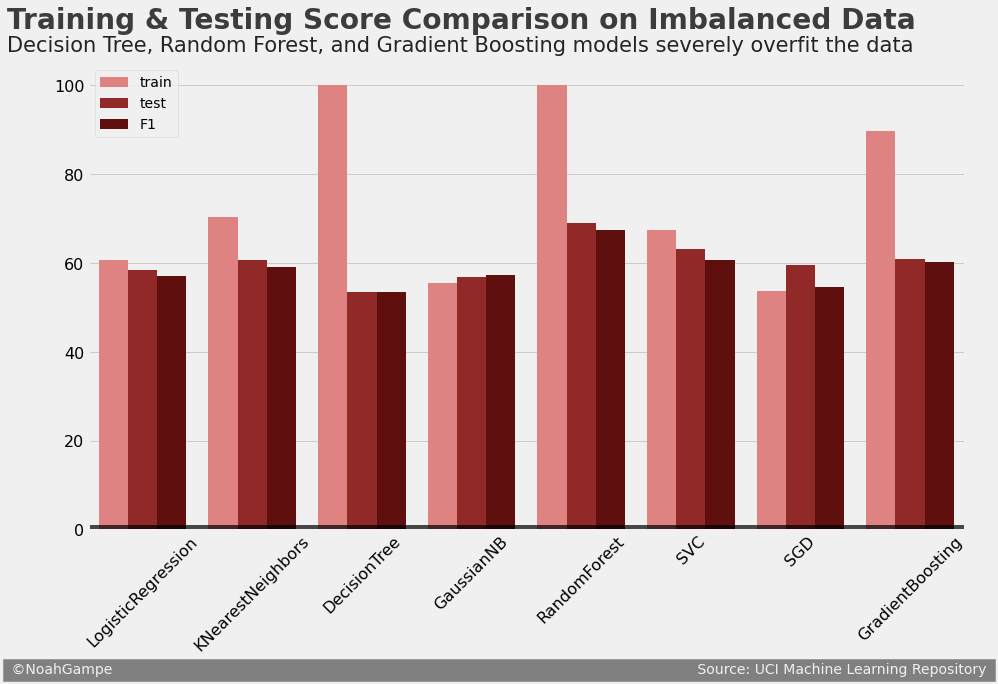

In [11]:
#needed for graph
imb_score_melted = pd.melt(imb_scores, id_vars='model',
                       value_vars=['training', 'test', 'F1'], var_name='pct')

title = "Training & Testing Score Comparison on Imbalanced Data"
sub = "Decision Tree, Random Forest, and Gradient Boosting models severely overfit the data"
tt_labels = ['train', 'test', 'F1']
plot_comparison(imb_score_melted, 'model', title, sub, tt_labels)

# Applying SMOTE - Synthetic Minority Over-sampling Technique

In [12]:
#define pipeline
over = SMOTE(n_jobs=-1)
under = RandomUnderSampler()
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

#transform dataset
X, y = pipeline.fit_resample(X, y)

#summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print(f'Quality={k+3}, n={v} ({per:.2f}%)')
    
#list to hold scores for SMOTE-balanced data set
bal_accuracy    = []
bal_precision   = []
bal_recall      = []
bal_f1          = []
bal_train_score = []
bal_test_score  = []

Quality=3, n=681 (16.67%)
Quality=4, n=681 (16.67%)
Quality=5, n=681 (16.67%)
Quality=6, n=681 (16.67%)
Quality=7, n=681 (16.67%)
Quality=8, n=681 (16.67%)


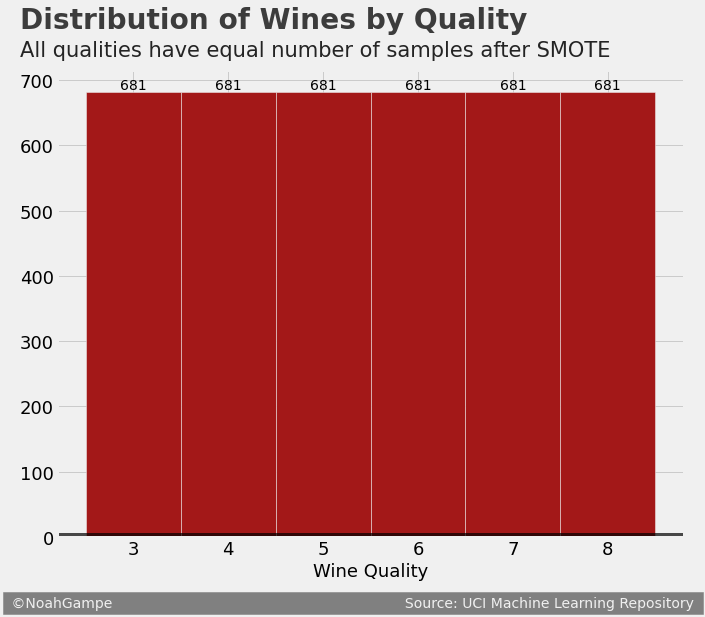

In [13]:
temp_y = pd.Series(y, name='quality')
smote_df = pd.concat([X, temp_y], axis=1)
smote_df['quality'] = smote_df['quality'] + 3

title = "Distribution of Wines by Quality"
sub = "All qualities have equal number of samples after SMOTE"
plot_dist(smote_df, 'quality', title, sub)

# Testing Models - Balanced Data

In [14]:
#split data into train and test sets - SMOTE has already been applied by this point
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#applying standard scaling to get optimized result
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

post_smote_reports = []
for i, pipe in enumerate(pipelines):
    print('*'*53)
    print(f'{pipe_dict[i]}')
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)

    #print classification report
    class_scores = precision_recall_fscore_support(y_test, predictions, average='weighted', zero_division=0)
    post_smote_reports.append(classification_report(y_test, predictions, digits=3, zero_division=0, target_names=labels))
    print(post_smote_reports[-1])
    
    #print train/test scores
    bal_accuracy.append(accuracy_score(y_test, predictions))
    bal_precision.append(round(class_scores[0]*100,3))
    bal_recall.append(round(class_scores[1]*100,3))
    bal_f1.append(round(class_scores[2]*100,3))
    bal_train_score.append(round(pipe.score(X_train, y_train)*100,3))
    bal_test_score.append(round(pipe.score(X_test, y_test)*100,3))
    print(f'Training Score: {bal_train_score[-1]}')
    print(f' Testing Score: {bal_test_score[-1]}\n')

*****************************************************
LOGISTIC REGRESSION
              precision    recall  f1-score   support

   Quality 3      0.771     0.874     0.819       135
           4      0.612     0.562     0.586       146
           5      0.538     0.507     0.522       140
           6      0.515     0.375     0.434       136
           7      0.503     0.583     0.540       127
           8      0.667     0.761     0.711       134

    accuracy                          0.609       818
   macro avg      0.601     0.610     0.602       818
weighted avg      0.602     0.609     0.602       818

Training Score: 59.884
 Testing Score: 60.88

*****************************************************
K-NEAREST NEIGHBOR CLASSIFIER
              precision    recall  f1-score   support

   Quality 3      0.900     1.000     0.947       135
           4      0.816     0.973     0.887       146
           5      0.689     0.507     0.584       140
           6      0.608     0.434   

# Training & Test Comparison

In [15]:
#create df for train/test scores
data = {'model': models,
        'training': bal_train_score,
        'test': bal_test_score,
        'F1': bal_f1}
bal_scores = pd.DataFrame(data=data)
bal_scores

,model,training,test,F1
0,LogisticRegression,59.884,60.880,60.159
1,KNearestNeighbors,84.945,78.973,77.359
2,DecisionTree,100.000,75.428,75.227
3,GaussianNB,52.050,50.856,48.367
4,RandomForest,100.000,87.286,86.813
5,SVC,80.018,77.506,76.340
6,SGD,54.070,52.567,51.484
7,GradientBoosting,91.922,76.528,75.449


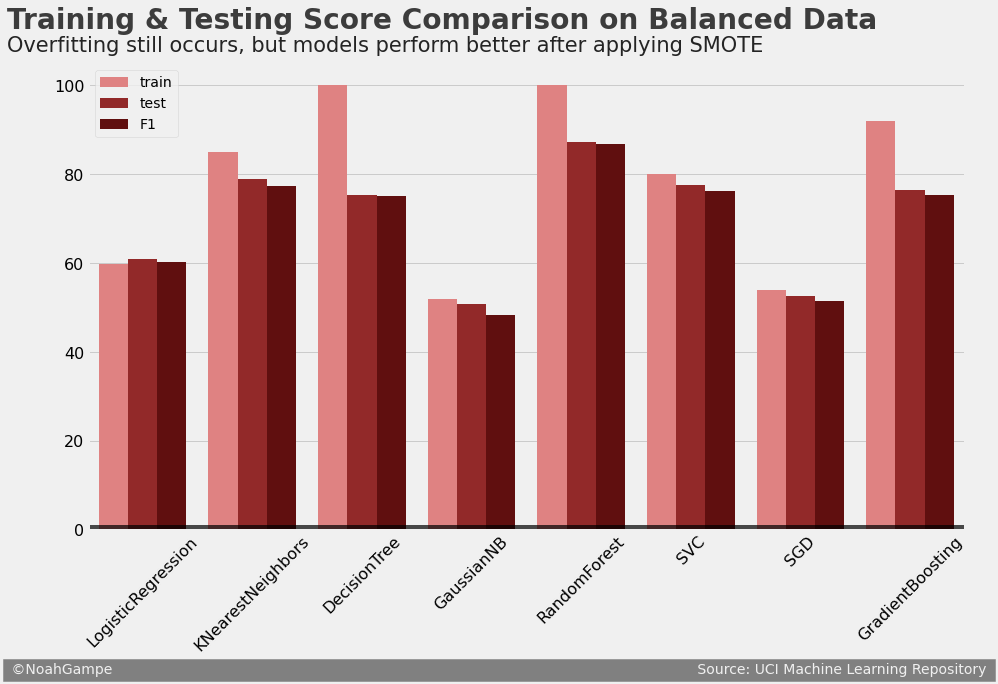

In [16]:
#needed for graph
bal_score_melted = pd.melt(bal_scores, id_vars='model',
                       value_vars=['training', 'test', 'F1'], var_name='pct')

title = "Training & Testing Score Comparison on Balanced Data"
sub = "Overfitting still occurs, but models perform better after applying SMOTE"
plot_comparison(bal_score_melted, 'model', title, sub, tt_labels)

# Comparing Model Performance

In [17]:
data = {'model': models,
        'pre-SMOTE acc': imb_accuracy,
        'post-SMOTE acc': bal_accuracy,
        'acc diff (%)': 0,
        'pre-SMOTE pre': imb_precision,
        'post-SMOTE pre': bal_precision,
        'pre diff (%)': 0,
        'pre-SMOTE rec': imb_recall,
        'post-SMOTE rec': bal_recall,
        'rec diff (%)': 0,
        'pre-SMOTE f1': imb_f1,
        'post-SMOTE f1': bal_f1,
        'f1 diff (%)': 0}
metrics = pd.DataFrame(data=data)
metrics['pre-SMOTE acc'] = round(metrics['pre-SMOTE acc']*100,3)
metrics['post-SMOTE acc'] = round(metrics['post-SMOTE acc']*100,3)
metrics['acc diff (%)'] = round((metrics['post-SMOTE acc'] / metrics['pre-SMOTE acc'] - 1) * 100,3)
metrics['pre diff (%)'] = round((metrics['post-SMOTE pre'] / metrics['pre-SMOTE pre'] - 1) * 100,3)
metrics['rec diff (%)'] = round((metrics['post-SMOTE rec'] / metrics['pre-SMOTE rec'] - 1) * 100,3)
metrics['f1 diff (%)'] = round((metrics['post-SMOTE f1'] / metrics['pre-SMOTE f1'] - 1) * 100,3)
metrics

,model,pre-SMOTE acc,post-SMOTE acc,acc diff (%),pre-SMOTE pre,post-SMOTE pre,pre diff (%),pre-SMOTE rec,post-SMOTE rec,rec diff (%),pre-SMOTE f1,post-SMOTE f1,f1 diff (%)
0,LogisticRegression,58.438,60.880,4.179,58.962,60.158,2.028,58.438,60.880,4.179,57.030,60.159,5.487
1,KNearestNeighbors,60.625,78.973,30.265,58.541,77.241,31.943,60.625,78.973,30.265,59.166,77.359,30.749
2,DecisionTree,53.438,75.428,41.150,53.874,75.236,39.652,53.438,75.428,41.150,53.514,75.227,40.574
3,GaussianNB,56.875,50.856,-10.583,59.777,48.260,-19.267,56.875,50.856,-10.583,57.373,48.367,-15.697
4,RandomForest,69.062,87.286,26.388,67.767,86.788,28.068,69.062,87.286,26.388,67.547,86.813,28.522
5,SVC,63.125,77.506,22.782,59.198,75.974,28.339,63.125,77.506,22.782,60.746,76.340,25.671
6,SGD,59.688,52.567,-11.930,55.183,54.935,-0.449,59.688,52.567,-11.930,54.711,51.484,-5.898
7,GradientBoosting,60.938,76.528,25.583,60.269,75.510,25.288,60.938,76.528,25.583,60.350,75.449,25.019


In [18]:
#needed for graphs
acc_melted = pd.melt(metrics, id_vars='model',
                     value_vars=['pre-SMOTE acc', 'post-SMOTE acc'], var_name='pct')
pre_melted = pd.melt(metrics, id_vars='model',
                     value_vars=['pre-SMOTE pre', 'post-SMOTE pre'], var_name='pct')
rec_melted = pd.melt(metrics, id_vars='model',
                     value_vars=['pre-SMOTE rec', 'post-SMOTE rec'], var_name='pct')
f1_melted  = pd.melt(metrics, id_vars='model',
                     value_vars=['pre-SMOTE f1', 'post-SMOTE f1'], var_name='pct')

melted_metrics = [acc_melted, pre_melted, rec_melted, f1_melted]
acc_labels = ['pre-SMOTE', 'post-SMOTE']
metric_labels = ["Accuracy", "Precision", "Recall", "F1"]

def plot_metric_comp(metrics, model_abbr=[], labels=[]):
    fig = plt.figure(figsize=(12,10))
    bar_colors = [wine_colors[1], wine_colors[3]]
        
    #for each metric, plot the comparison
    for i in range(len(metrics)):
        #subplot details        
        if i > 0:
            ax = fig.add_subplot(2,2,i+1, sharey=ax)
        else:
            ax = fig.add_subplot(2,2,i+1)
        
        #plot
        ax = sns.barplot(data=metrics[i], x='model', y='value', hue='pct', palette=bar_colors)
        
        #lines, limits, & labels
        if not model_abbr:
            ticks = ["LR", "KNN", "DT", "GNB", "RF", "SVC", "SGD", "GB"]
            ax.set_ylim(40,91)
            ax.axhline(y=40, color='black', linewidth=10, alpha=.7)
        else: #our best performing model
            ticks = model_abbr
            ax.set_ylim(70,90)
            ax.axhline(y=70, color='black', linewidth=10, alpha=.7)
            for j in ax.containers:
                ax.bar_label(j,)
        
        ax.set_xticklabels(ticks)
        ax.yaxis.label.set_visible(False)
        ax.xaxis.label.set_visible(False)
        ax.set_title(metric_labels[i])
        if i != 0 and i != 2:
            ax.tick_params(labelleft=False)            
            
        #legend
        if i == len(metrics)-1:
            h,_ = ax.get_legend_handles_labels()
            ax.legend(loc=4, frameon=True, handles=h, labels=labels, framealpha=1)
        else:
            ax.get_legend().set_visible(False)
            
    #figure title & subtitle
    title = "Metric Comparison Before & After Applying SMOTE"
    sub = "Most models see an increase in all metrics after balancing data"
    ax.text(0.03,0.965, s=title, fontsize=28, weight='bold', alpha=.75, transform=fig.transFigure)
    ax.text(0.03,0.93, s=sub, fontsize=21, alpha=.85, transform=fig.transFigure)

    #signature bar
    ax.text(x=0.03, y=0, s=' ©NoahGampe' + ' '*92 + 'Source: UCI Machine Learning Repository ',
            fontsize=14, color='#f0f0f0', backgroundcolor='grey', transform=fig.transFigure)
        
    plt.show()   

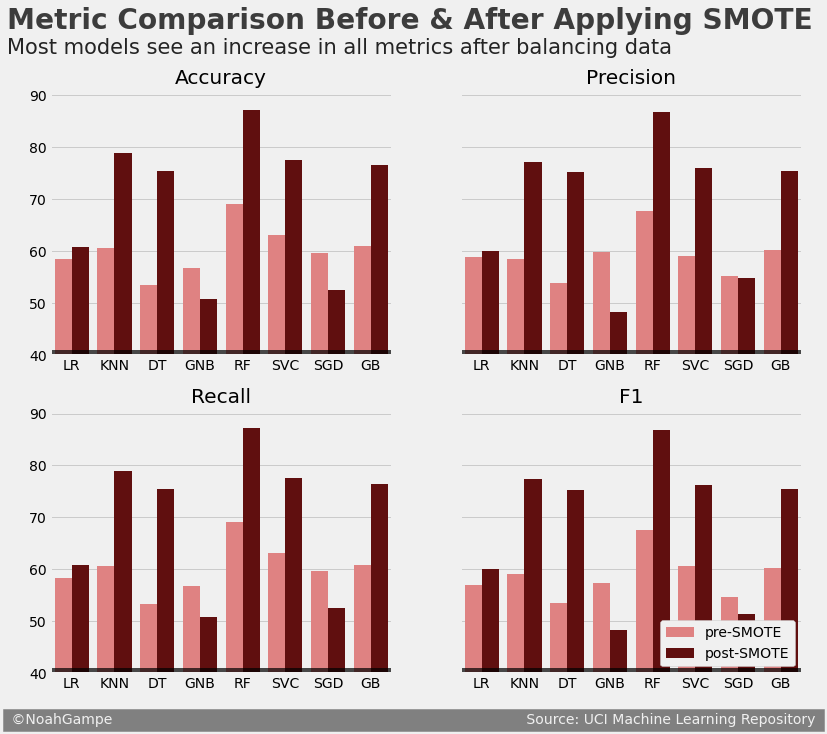

In [19]:
plot_metric_comp(melted_metrics, labels=acc_labels)       

## Observations

* After using SMOTE to balance the dataset, we can clearly see an increase in all 4 of our metrics across most of our models
* According to our **F1** score, our `RandomForestClassifier` is the top performer
* The tree-based models, along with the `KNN`, `SVC`, and `GB` models saw the biggest improvement in F1 scores, while our `LR`, `GNB`, and `SGD` models saw little improvement (and even a decrease) in F1 score

# Using GridSearch to Improve Performance

Let's take our 4 best performing models and see if we can further improve their performance by optimizing them via GridSearch. Our 4 best performing models are:

* RandomForest
* SVC
* KNearestNeighbors
* GradientBoosting

There *is* a slight chance that the performance doesn't improve much, or it actually decrease a little bit, since it is using cross validation with 10 folds and taking the average score. It's still a good thing to try to get as much performance from our model as possible.

In [20]:
def select_model(X_train, y_train):        
    print('Using GridSearchCV...\n')
    model_params = [
    {
        "name": "KNeighborsClassifier",
        "estimator": KNeighborsClassifier(n_jobs=-1),
        "hyperparameters":
            {
                "n_neighbors": range(1,21),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
            }
    },
    {
        "name": "RandomForestClassifier",
        "estimator": RandomForestClassifier(random_state=1, n_jobs=-1),
        "hyperparameters":
            {
                "n_estimators": [50, 100, 150],
                "criterion": ["entropy", "gini"],
                "max_depth": [5, 10, 15],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]
            }
    },
    {
        "name": "SupportVectorClassifier",
        "estimator": SVC(),
        "hyperparameters":
            {
                "kernel": ['rbf', 'linear', 'poly', 'sigmoid'],
                "gamma": ['scale', 'auto'],
                "C": [3.0, 2.0, 1.0, 0.1]
            }
    },
    {
        "name": "GradientBoostingClassifier",
        "estimator": GradientBoostingClassifier(random_state=1),
        "hyperparameters": 
            {
                "n_estimators": [10, 50, 100],
                "max_depth": [3, 5, 8],
                "min_samples_split": [2, 3, 5],
                "min_samples_leaf": [1, 3, 5]                
            }
    }]
    
    for model in model_params:
        #print name
        print(f'Model: {model["name"]}')
                
        #instantiate gridsearch
        grid = GridSearchCV(model['estimator'],
                            param_grid=model['hyperparameters'],
                            cv=10,
                            n_jobs=-1)

        grid.fit(X_train, y_train)
        
        #assign to dictionary
        model['best_params']  = grid.best_params_
        model['best_score']   = grid.best_score_
        model['best_model']   = grid.best_estimator_
        model['best_report']  = classification_report(y_test, grid.best_estimator_.predict(X_test),
                                                     digits=3, zero_division=0, target_names=labels)
        model['best_acc']     = accuracy_score(y_test, grid.best_estimator_.predict(X_test))
        model['best_metrics'] = precision_recall_fscore_support(y_test, grid.best_estimator_.predict(X_test), 
                                                                average='weighted', zero_division=0)
        
        bal_accuracy.append(accuracy_score(y_test, predictions))
        bal_precision.append(round(class_scores[0]*100,3))
        bal_recall.append(round(class_scores[1]*100,3))
        bal_f1.append(round(class_scores[2]*100,3))
        
        #print best score and parameters
        print(f'Best Score: {model["best_score"]}')
        print(f'Best Params: {model["best_params"]}')
        print('-'*(len(model['name'])+7))
 
    print('Finished!')
    return model_params

In [21]:
#currently takes ~10 minutes
best_performers = select_model(X_train, y_train)

Using GridSearchCV...

Model: KNeighborsClassifier
Best Score: 0.8445479446914692
Best Params: {'algorithm': 'ball_tree', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}
---------------------------
Model: RandomForestClassifier
Best Score: 0.8635138177520121
Best Params: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 150}
-----------------------------
Model: SupportVectorClassifier
Best Score: 0.8007898538488959
Best Params: {'C': 3.0, 'gamma': 'auto', 'kernel': 'rbf'}
------------------------------
Model: GradientBoostingClassifier
Best Score: 0.868410536387685
Best Params: {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}
---------------------------------
Finished!


In [22]:
#use best performing model from select_model results
results = max(best_performers, key=lambda x:x['best_score'])
index = best_performers.index(results)
best_model = results['best_model']
print(f'Best performing model: {best_model}')
print(results['best_report'])

Best performing model: GradientBoostingClassifier(max_depth=8, min_samples_leaf=5, random_state=1)
              precision    recall  f1-score   support

   Quality 3      0.964     1.000     0.982       135
           4      0.867     0.938     0.901       146
           5      0.800     0.657     0.722       140
           6      0.684     0.669     0.677       136
           7      0.864     0.898     0.880       127
           8      0.943     0.985     0.964       134

    accuracy                          0.857       818
   macro avg      0.854     0.858     0.854       818
weighted avg      0.853     0.857     0.853       818



In [23]:
model_map = {0: 1,
             1: 4,
             2: 5,
             3: 7}

acc_comp = [round(bal_accuracy[model_map[index]]*100,3) ,round(results['best_acc']*100,3)]
pre_comp = [bal_precision[model_map[index]] ,round(results['best_metrics'][0]*100,3)]
rec_comp = [bal_recall[model_map[index]] ,round(results['best_metrics'][1]*100,3)]
f1_comp  = [bal_f1[model_map[index]] ,round(results['best_metrics'][2]*100,3)]

data = {'model': models[model_map[index]],        
        'pre_acc': acc_comp[0],
        'post_acc': acc_comp[1],
        'pre_pre': pre_comp[0],
        'post_pre': pre_comp[1],
        'pre_rec': rec_comp[0],
        'post_rec': rec_comp[1],
        'pre_f1': f1_comp[0],
        'post_f1': f1_comp[1],
        }

optimized = pd.DataFrame(data=[data])

#needed for graph
opt_acc_melted = pd.melt(optimized, id_vars='model',
                     value_vars=['pre_acc', 'post_acc'], var_name='pct')
opt_pre_melted = pd.melt(optimized, id_vars='model',
                     value_vars=['pre_pre', 'post_pre'], var_name='pct')
opt_rec_melted = pd.melt(optimized, id_vars='model',
                     value_vars=['pre_rec', 'post_rec'], var_name='pct')
opt_f1_melted  = pd.melt(optimized, id_vars='model',
                     value_vars=['pre_f1', 'post_f1'], var_name='pct')

opt_metrics = [opt_acc_melted, opt_pre_melted, opt_rec_melted, opt_f1_melted]
gs_labels = ['pre-GridSearch', 'post-GridSearch']

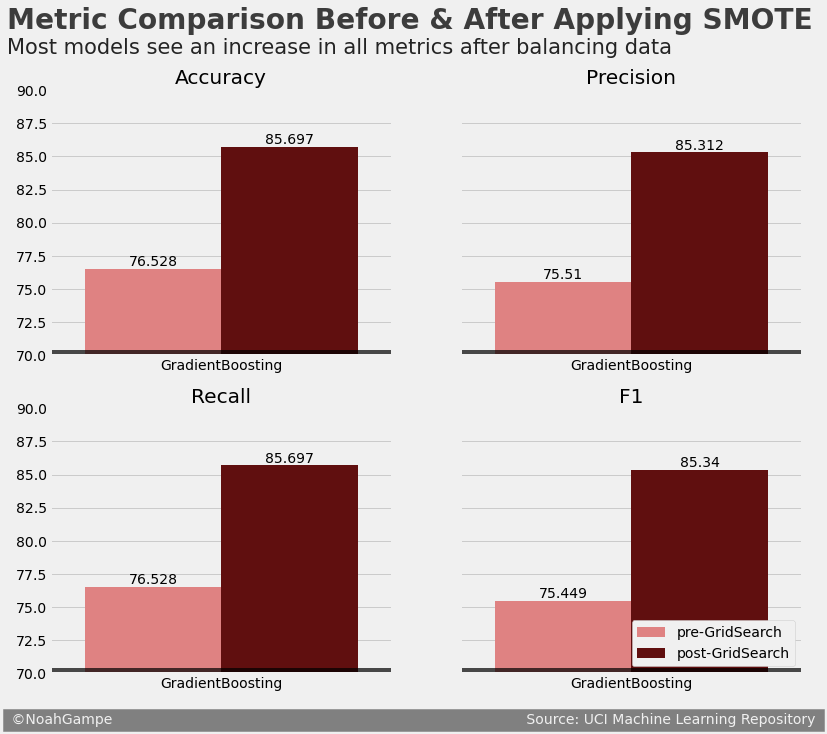

In [24]:
plot_metric_comp(opt_metrics, model_abbr=[models[model_map[index]]], labels=gs_labels)

# Conclusion

As we can see from above, using `GridSearchCV` to find the best hypterparameter settings increased the accuracy of most of our tested models! Both the `KNearestNeighbors` and `GradientBoostingClassifier` models saw the largest increases. We can see that using `GridSearchCV` had a very minor impact on our metrics for our best performing model. Sometimes it may increase the metrics slightly, other times it may not.

## Final Thoughts

* Imbalanced data causes inaccuracies with classification models
* `SMOTE` can synthesize new samples from the minority class to "balance" the distribution of sample classes
* Pipelines can help streamline the process of testing multiple models
* `GridSearchCV` improved our model's performance by tuning the hyperparameters
* Our model was able to predict a wine's quality, based on the given chemical characteristics, with a respectable performance

## Further Steps

* Continue to tweak hyperparameters
* Add more models to pipeline
* Perform same analysis on the white wine dataset